In [2]:
!sudo pip uninstall -y pydot

The directory '/Users/rlx/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Cannot uninstall requirement pydot, not installed
The directory '/Users/rlx/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas, numpy, theano, time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, TimeDistributedDense
from keras.layers.recurrent import LSTM
%matplotlib inline

In [4]:
def build_sequences(signal, seq_len):
    result = []
    for index in range(len(signal) - seq_len):
        result.append(signal[index: index + seq_len])
    result = np.array(result)  
    return result

## 1. Señal sintética

Creamos primero una señal sintética para nuestros experimentos. Puedes experimentar con este cambiando la señal sintética. 

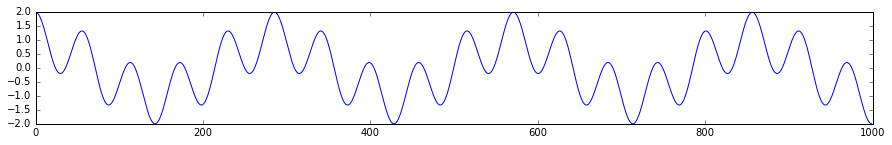

In [5]:
n_samples = 1000
signal_range = np.linspace(0, 7*np.pi, num=n_samples, dtype=np.float32)
S = np.cos(signal_range*5)+np.cos(signal_range)
# otras dos señales sinteticas
#S = np.cos(signal_range)
#S = signal_range/np.max(signal_range)
plt.figure(figsize=(15,2))
plt.plot(S)


## 2. Construcción de secuencias.

Construimos un dataset de secuencias. Las secuencias son consecutivas y superpuestas. Para cada secuencia queremos usar todos los elementos menos el último para predecir el último. Observa como las primeras dos secuencias de entrenamiento son iguales pero desplazadas un paso de tiempo. Tomamos también el 25% de la señal para entrenamiento y el resto para probar los modelos que creemos.

In [6]:
look_back = 40
train_pct = 0.26
row = int(train_pct * len(S))

X_tr = build_sequences(S[:row], look_back)
X_ts = build_sequences(S[row:], look_back)

X_train = X_tr[:, :-1]
y_train = X_tr[:, -1]

X_test  = X_ts[:, :-1]
y_test  = X_ts[:, -1]
print X_train[0]
print X_train[1]

[ 2.          1.99370658  1.97489977  1.94379854  1.90076542  1.84630132
  1.78104031  1.70574117  1.62127876  1.52863336  1.42887831  1.32316792
  1.21272302  1.09881628  0.9827565   0.86587346  0.74950159  0.63496351
  0.52355456  0.41652691  0.3150748   0.22031921  0.13329577  0.0549407
 -0.01391906 -0.07257652 -0.12045342 -0.15710622 -0.18223238 -0.19567329
 -0.19741631 -0.18759513 -0.16648763 -0.13451272 -0.09222519 -0.04030859
  0.02043253  0.08908302  0.16462803]
[ 1.99370658  1.97489977  1.94379854  1.90076542  1.84630132  1.78104031
  1.70574117  1.62127876  1.52863336  1.42887831  1.32316792  1.21272302
  1.09881628  0.9827565   0.86587346  0.74950159  0.63496351  0.52355456
  0.41652691  0.3150748   0.22031921  0.13329577  0.0549407  -0.01391906
 -0.07257652 -0.12045342 -0.15710622 -0.18223238 -0.19567329 -0.19741631
 -0.18759513 -0.16648763 -0.13451272 -0.09222519 -0.04030859  0.02043253
  0.08908302  0.16462803  0.24596491]


Reformateamos los datos para el tipo de estructura que requiere nuestra libería

In [7]:
print "Estructura inicial", X_train.shape, X_test.shape
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print "Estructura final  ", X_train.shape, X_test.shape, y_train.shape, y_test.shape

Estructura inicial (220, 39) (700, 39)
Estructura final   (220, 1, 39) (700, 1, 39) (220,) (700,)


Fíjate en la parte que queda para test y para train. Observa igualemente el tamaño de las secuencias construidas respecto a la señal.

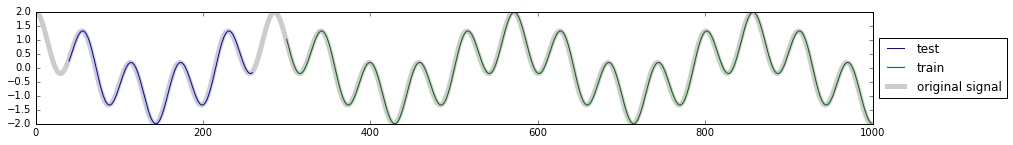

In [8]:
plt.figure(figsize=(15,2))
plt.plot(list(np.zeros(look_back)*np.nan)+list(y_train), label="test", color="blue")
plt.plot(list(np.zeros(len(y_train)+2*look_back)*np.nan)+list(y_test), label="train", color="green")
plt.plot(S, lw=5, alpha=.2, label="original signal", color="black")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## 3. Diseño y entrenamiento de RNN

construimos una red LSTM sencilla. Fíjate que el último paso (`compile`), compila a código nativo y es computacionalmente algo pesado.

In [9]:
model = Sequential()
n_out=5
model.add(LSTM(output_dim=n_out, input_dim=look_back-1))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
init_weights = model.get_weights()

entrenamos el modelo con los datos de entrenamiento. Observe how after a few iterations we get little improvement

In [10]:
model.set_weights(init_weights)
h = model.fit(X_train, y_train, nb_epoch=15, batch_size=1, validation_split=.15, verbose=0)

(0, 0.63293172330775316)

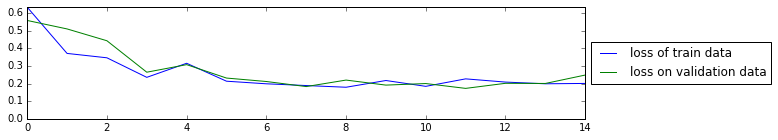

In [11]:
plt.figure(figsize=(10,2))
plt.plot(h.history["loss"], label="loss of train data")
plt.plot(h.history["val_loss"], label="loss on validation data")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,np.max(list(h.history["val_loss"])+list(h.history["loss"]))])

## 4. Prediciones de la RNN

Obtenemos predicciones para los datos de entrenamiento y para los de test.

In [12]:
trainPredict = model.predict(X_train)[:,0]
testPredict = model.predict(X_test)[:,0]
from sklearn.metrics import mean_squared_error
print "MSE train %.3f"%mean_squared_error(trainPredict, y_train)
print "MSE test  %.3f"%mean_squared_error(testPredict, y_test)

MSE train 0.103
MSE test  0.174


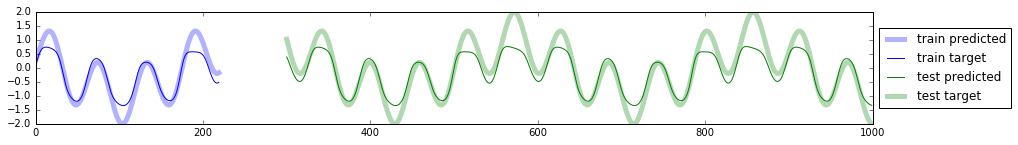

In [13]:
plt.figure(figsize=(15,2))
plt.plot(y_train, color="blue", lw=5, alpha=.3, label="train predicted")
plt.plot(trainPredict, color="blue", label="train target")
padding = np.ones(len(trainPredict)+2*look_back)*np.nan
plt.plot(list(padding)+list(testPredict), color="green", label="test predicted")
plt.plot(list(padding)+list(y_test), color="green", lw=5, alpha=.3, label="test target")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## 5. Predicción sobre otras señales

probamos el mismo modelo (entrenado con la señal anterior) para predecir otro tipo de señal.

In [14]:
signal_range = np.linspace(0, 7*np.pi, num=1000, dtype=np.float32)
S2 = np.cos(signal_range)*np.abs(signal_range-np.max(signal_range)/2)/20 #*np.cos(signal_range/3)
S2 = 2*S2**2+.3
X2 = build_sequences(S2, look_back)

X2frames = X2[:, :-1]
y2       = X2[:, -1]

X2frames = np.reshape(X2frames, (X2frames.shape[0], 1, X2frames.shape[1]))
print y2.shape, X2frames.shape 

(960,) (960, 1, 39)


MSE 0.019


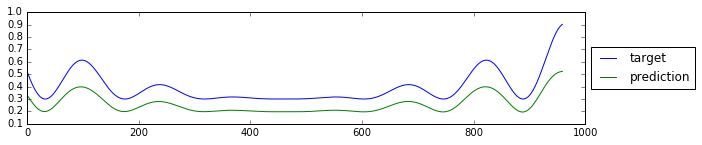

In [15]:
plt.figure(figsize=(10,2))
preds = model.predict(X2frames)[:,0]
print "MSE %.3f"%mean_squared_error(preds, y2)
plt.plot(y2, label="target")
plt.plot(preds, label="prediction")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 6. Generación de señales

usamos el modelo para generar una nueva señal, a partir de una muestra de una señal cualquiera

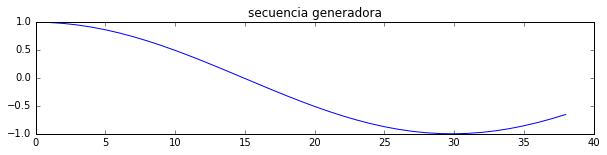

In [16]:
init_seq = np.ones(X_test.shape[2]).reshape(1,1,X_test.shape[2])
#init_seq = np.linspace(0,4,X_test.shape[2]).reshape(1,1,X_test.shape[2])
#init_seq = np.random.random(X_test.shape[2]).reshape(1,1,X_test.shape[2])
init_seq = np.cos(np.linspace(0,4,X_test.shape[2]).reshape(1,1,X_test.shape[2]))
plt.figure(figsize=(10,2))
plt.plot(init_seq[0,0])
plt.title("secuencia generadora")

In [17]:
preds=[]
seq = init_seq.copy()
for i in range(2000):
    pred=model.predict(seq)[0][0]
    preds.append(pred)
    seq=np.array(list(seq[0,0,1:])+[pred]).reshape(1,1,X_test.shape[2])

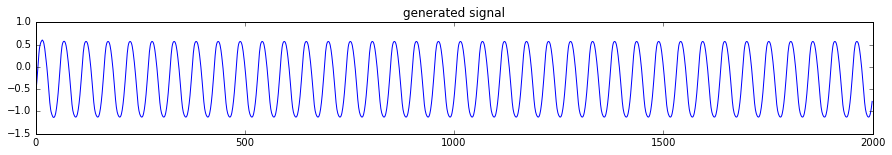

In [18]:
plt.figure(figsize=(15,2))
plt.plot(preds)
plt.title("generated signal")

## Otros experimentos

Experimentos que puedes hacer:

- Usa otras señales sintéticas (p.ej. no periódicas)
- Cambia el porcentaje de entrenamiento (variable `train_pct`, p.ej. 0.01, o 0.5)
- Cambia el tamaño de las secuencias (variable `look_back`)
- Cambia la resolución de la señal (variable `n_samples`, quizá tengas que ajsutar también `look_back`)
- Cambia el tamaño de la salida de la celda LSTM (variable `n_out`, p.ej. 2, 20, 64) o el porcentaje de dropout
- Usa una red más compleja. P.ej. de dos capas:
        model = Sequential()
        model.add(LSTM(64, input_dim=look_back-1, return_sequences=True))
        model.add(Dropout(0.5))
        model.add(LSTM(128))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
- Usar el modelo para predecir distintas señales
- Usar distintas secuencias generadoras